In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!unzip -q "/content/drive/MyDrive/RSICD.zip" -d "/content"

replace /content/RSICD/images/airport_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/RSICD/images/airport_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/RSICD/images/airport_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n


In [11]:
!pip install nltk tqdm pycocoevalcap --quiet
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Set your paths to dataset here
image_folder = '/content/RSICD/images'
json_path = '/content/RSICD/sentences/Dataset.json'


In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import os
import json
from PIL import Image
from tqdm import tqdm
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# SECTION 2: Dataset and Vocabulary

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        return text.lower().strip().split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [
            self.stoi.get(token, self.stoi["<unk>"])
            for token in self.tokenizer(text)
        ]
# SECTION 3: Dataset Loader

class RSICDDataset(Dataset):
    def __init__(self, root_dir, json_path, vocab, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        with open(json_path, 'r') as f:
            self.data = json.load(f)['images']

        all_captions = [ann['raw'] for img in self.data for ann in img['sentences']]
        self.vocab.build_vocabulary(all_captions)

        self.images = []
        self.captions = []

        for img in self.data:
            path = img['filename']
            for sentence in img['sentences']:
                self.images.append(path)
                self.captions.append(sentence['raw'])

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<end>"])
        return image, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

In [15]:
# SECTION 5: Encoder (ResNet)

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False
        modules = list(resnet.children())[:-2]  # remove avgpool and fc
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))
        self.conv = nn.Conv2d(2048, embed_size, 1)

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = self.conv(features)  # (B, embed_size, 14, 14)
        features = features.view(features.size(0), features.size(1), -1).permute(0, 2, 1)  # (B, 196, embed_size)
        return features


class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)
        att = self.full_att(torch.tanh(att1 + att2)).squeeze(2)
        alpha = torch.softmax(att, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha


class DecoderWithAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim, encoder_dim=256, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        vocab_size = self.fc.out_features
        num_steps = captions.size(1)

        embeddings = self.embedding(captions)
        h, c = torch.zeros(batch_size, 512).to(device), torch.zeros(batch_size, 512).to(device)
        outputs = torch.zeros(batch_size, num_steps, vocab_size).to(device)

        for t in range(num_steps):
            context, _ = self.attention(encoder_out, h)
            lstm_input = torch.cat([embeddings[:, t], context], dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(h))
            outputs[:, t] = output

        return outputs


In [16]:
def generate_caption(encoder, decoder, image, vocab, max_len=50):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        encoder_out = encoder(image)
        h, c = torch.zeros(1, 512).to(device), torch.zeros(1, 512).to(device)

        caption = [vocab.stoi["<start>"]]
        for _ in range(max_len):
            word = torch.tensor([caption[-1]]).to(device)
            embedding = decoder.embedding(word)
            context, _ = decoder.attention(encoder_out, h)
            lstm_input = torch.cat([embedding.squeeze(0), context.squeeze(0)], dim=0).unsqueeze(0)
            h, c = decoder.lstm(lstm_input, (h, c))
            output = decoder.fc(h)
            predicted = output.argmax(1).item()
            caption.append(predicted)
            if predicted == vocab.stoi["<end>"]:
                break

    return [vocab.itos[idx] for idx in caption[1:-1]]


In [17]:
# SECTION 8: Training Setup

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

vocab = Vocabulary(freq_threshold=5)
dataset = RSICDDataset("/content/RSICD/images", "/content/RSICD/sentences/Dataset.json", vocab, transform)
pad_idx = vocab.stoi["<pad>"]
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=MyCollate(pad_idx))


encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderWithAttention(embed_size=256, hidden_size=512, vocab_size=len(vocab),
                               attention_dim=256).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
params = list(decoder.parameters()) + list(encoder.conv.parameters())
optimizer = torch.optim.Adam(params, lr=3e-4)

num_epochs = 5
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for imgs, captions in tqdm(loader):
        imgs, captions = imgs.to(device), captions.to(device)
        encoder_out = encoder(imgs)
        outputs = decoder(encoder_out, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# Save model
torch.save({
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict()
}, "/content/attention_model.pth")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]
100%|██████████| 1707/1707 [06:08<00:00,  4.64it/s]


Epoch 1, Loss: 2.1725


100%|██████████| 1707/1707 [06:00<00:00,  4.74it/s]


Epoch 2, Loss: 1.5248


100%|██████████| 1707/1707 [05:59<00:00,  4.75it/s]


Epoch 3, Loss: 1.3481


100%|██████████| 1707/1707 [06:00<00:00,  4.73it/s]


Epoch 4, Loss: 1.2318


100%|██████████| 1707/1707 [05:58<00:00,  4.76it/s]


Epoch 5, Loss: 1.1448


In [18]:
 nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from random import sample

In [20]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(encoder, decoder, dataloader, vocab):
    references, hypotheses = [], []
    encoder.eval()
    decoder.eval()

    for imgs, captions in tqdm(dataloader):
        imgs = imgs.to(device)
        for img, caption in zip(imgs, captions):
            pred = generate_caption(encoder, decoder, img, vocab)
            target = [vocab.itos[idx.item()] for idx in caption
                      if idx.item() not in {vocab.stoi["<pad>"], vocab.stoi["<start>"], vocab.stoi["<end>"]}]
            references.append([" ".join(target)])
            hypotheses.append(" ".join(pred))

    print("BLEU-1:", corpus_bleu([[ref[0].split()] for ref in references], [hyp.split() for hyp in hypotheses], weights=(1, 0, 0, 0)))
    print("BLEU-4:", corpus_bleu([[ref[0].split()] for ref in references], [hyp.split() for hyp in hypotheses], weights=(0.25, 0.25, 0.25, 0.25)))

In [21]:
def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    vocab = Vocabulary(freq_threshold=5)
    dataset = RSICDDataset("/content/RSICD/images", "/content/RSICD/sentences/Dataset.json", vocab, transform)
    dataset.data = random.sample(dataset.data, 500)  # Subsample for fast evaluation
    pad_idx = vocab.stoi["<pad>"]
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=MyCollate(pad_idx))

    encoder = EncoderCNN(embed_size=256).to(device)
    decoder = DecoderWithAttention(embed_size=256, hidden_size=512, vocab_size=len(vocab),
                                   attention_dim=256).to(device)

    checkpoint = torch.load("/content/attention_model.pth")
    encoder.load_state_dict(checkpoint["encoder"])
    decoder.load_state_dict(checkpoint["decoder"])

    evaluate_model(encoder, decoder, dataloader, vocab)

main()

100%|██████████| 3413/3413 [15:29<00:00,  3.67it/s]


BLEU-1: 0.5849795813493383
BLEU-4: 0.35918616091747485


In [30]:
def greedy_decode(encoder, decoder, image, vocab, max_len=50):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # The problem was in this line. It was trying to call unsqueeze on the decoder,
        # but unsqueeze is a method for tensors, not for the decoder object.
        # The line should call unsqueeze on the image tensor instead.
        image = image.unsqueeze(0).to(device)  # Corrected line
        encoder_out = encoder(image)
        h, c = torch.zeros(1, 512).to(device), torch.zeros(1, 512).to(device)

        caption = [vocab.stoi["<start>"]]
        for _ in range(max_len):
            prev_word = torch.tensor([caption[-1]]).to(device)
            embedding = decoder.embedding(prev_word)
            context, _ = decoder.attention(encoder_out, h)
            lstm_input = torch.cat([embedding.squeeze(0), context.squeeze(0)], dim=0).unsqueeze(0)
            h, c = decoder.lstm(lstm_input, (h, c))
            output = decoder.fc(h)
            next_token = output.argmax(1).item()
            caption.append(next_token)
            if next_token == vocab.stoi["<end>"]:
                break

    return [vocab.itos[idx] for idx in caption[1:-1]]

Generated Caption: many green trees and several buildings are in a resort .


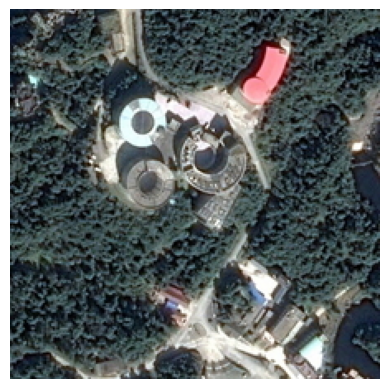

In [31]:
from random import randint
import matplotlib.pyplot as plt

encoder.eval()
decoder.eval()

# Random image
index = randint(0, len(dataset) - 1)
image, _ = dataset[index]

# Generate caption
# The original code was calling greedy_decode with the decoder instead of the encoder
# caption_words = greedy_decode(decoder, image, vocab)  # Incorrect

# The correct call is with the encoder
caption_words = greedy_decode(encoder, decoder, image, vocab)  # Correct
print("Generated Caption:", " ".join(caption_words))

# Show image
plt.imshow(transforms.ToPILImage()(image))
plt.axis('off')
plt.show()